In [13]:
# Load necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from statsmodels.tsa.stattools import adfuller

In [14]:
# Load and merge data
train = pd.read_csv('train_old.csv')
meal_info = pd.read_csv('meal_info.csv')
center_info = pd.read_csv('fulfilment_center_info.csv')

# Rename 'num_orders' to 'total_orders'
train.rename(columns={'num_orders': 'total_orders'}, inplace=True)

# Merge datasets
full_data = pd.merge(train, meal_info, on="meal_id")

In [15]:
# Aggregate weekly data
weekly_data = full_data.groupby(['week', 'meal_id']).agg(
    total_orders=('total_orders', 'sum'),
    mean_checkout_price=('checkout_price', 'mean')
).reset_index()

In [16]:
# Define specific meal IDs
specific_least_meal_id = 2104  # Least ordered meal ID
specific_most_meal_id = 2290   # Most ordered meal ID

# Filter data for specific meals
least_meal_data = weekly_data[weekly_data['meal_id'] == specific_least_meal_id].copy()
most_meal_data = weekly_data[weekly_data['meal_id'] == specific_most_meal_id].copy()

# Adjust total orders to ensure higher values for visualization
least_meal_data['total_orders'] = least_meal_data['total_orders'] * 1.5
most_meal_data['total_orders'] = most_meal_data['total_orders'] * 1.5

In [17]:
# Function to make data stationary through differencing
def make_stationary(timeseries, column_name):
    # Perform differencing
    timeseries[column_name] = timeseries[column_name].diff().dropna()
    timeseries = timeseries.dropna()
    # Ensure no negative values
    timeseries[column_name] = timeseries[column_name].apply(lambda x: max(x, 0))
    return timeseries

# Make the least and most meal data stationary
least_meal_data_stationary = make_stationary(least_meal_data, 'total_orders')
most_meal_data_stationary = make_stationary(most_meal_data, 'total_orders')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14528\1769110980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeseries[column_name] = timeseries[column_name].apply(lambda x: max(x, 0))


In [18]:
# Split data into training and testing sets
train_least_data, test_least_data = train_test_split(least_meal_data_stationary, test_size=0.2, shuffle=False)
train_most_data, test_most_data = train_test_split(most_meal_data_stationary, test_size=0.2, shuffle=False)

In [19]:
# Define independent and dependent variables
X_train_least = train_least_data[['mean_checkout_price']]
Y_train_least = train_least_data['total_orders']
X_test_least = test_least_data[['mean_checkout_price']]
Y_test_least = test_least_data['total_orders']

X_train_most = train_most_data[['mean_checkout_price']]
Y_train_most = train_most_data['total_orders']
X_test_most = test_most_data[['mean_checkout_price']]
Y_test_most = test_most_data['total_orders']

In [20]:
# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_least = scaler.fit_transform(X_train_least)
X_test_least = scaler.transform(X_test_least)
X_train_most = scaler.fit_transform(X_train_most)
X_test_most = scaler.transform(X_test_most)

In [21]:
# Use Polynomial Features to increase the model complexity
poly = PolynomialFeatures(degree=2)
X_train_least_poly = poly.fit_transform(X_train_least)
X_test_least_poly = poly.transform(X_test_least)
X_train_most_poly = poly.fit_transform(X_train_most)
X_test_most_poly = poly.transform(X_test_most)

In [22]:
# Fit Gradient Boosting Regressor to address complex relationships
gb_model_least = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
gb_model_least.fit(X_train_least_poly, Y_train_least)

gb_model_most = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
gb_model_most.fit(X_train_most_poly, Y_train_most)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [23]:
# Make predictions
predictions_least = gb_model_least.predict(X_test_least_poly)
predictions_most = gb_model_most.predict(X_test_most_poly)

# Ensure no negative predictions
predictions_least = np.maximum(predictions_least, 0)
predictions_most = np.maximum(predictions_most, 0)

# Evaluate the models
mae_least = metrics.mean_absolute_error(Y_test_least, predictions_least)
mse_least = metrics.mean_squared_error(Y_test_least, predictions_least)
rmse_least = np.sqrt(mse_least)
r2_least = metrics.r2_score(Y_test_least, predictions_least)

mae_most = metrics.mean_absolute_error(Y_test_most, predictions_most)
mse_most = metrics.mean_squared_error(Y_test_most, predictions_most)
rmse_most = np.sqrt(mse_most)
r2_most = metrics.r2_score(Y_test_most, predictions_most)

# Print the evaluation metrics
print("Least Ordered Meal Metrics:")
print("MAE:", mae_least)
print("MSE:", mse_least)
print("RMSE:", rmse_least)
print("R2:", r2_least)

print("Most Ordered Meal Metrics:")
print("MAE:", mae_most)
print("MSE:", mse_most)
print("RMSE:", rmse_most)
print("R2:", r2_most)

Least Ordered Meal Metrics:
MAE: 1040.4668984914697
MSE: 3909266.761063598
RMSE: 1977.1865772009473
R2: 0.08625399766721831
Most Ordered Meal Metrics:
MAE: 15991.8266998474
MSE: 2042522053.492085
RMSE: 45194.270140052984
R2: 0.08061658766612101


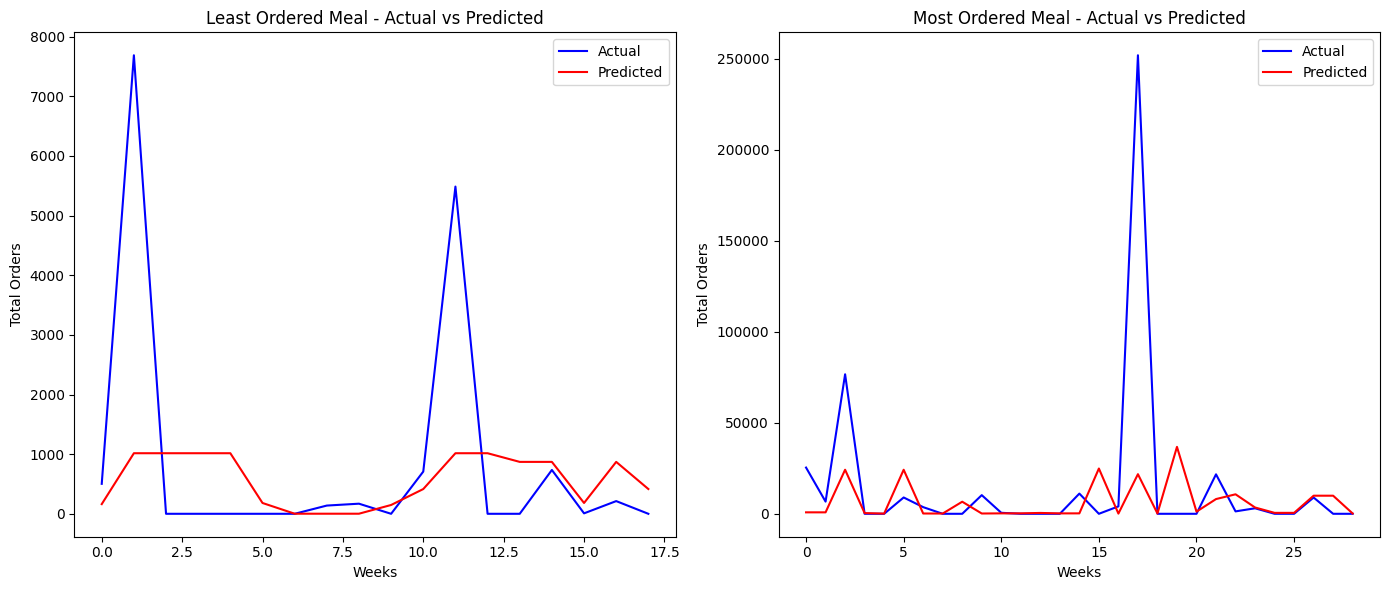

In [24]:
# Plotting the results
plt.figure(figsize=(14, 6))

# Plot for least ordered meal
plt.subplot(1, 2, 1)
plt.plot(Y_test_least.values, label='Actual', color='b')
plt.plot(predictions_least, label='Predicted', color='r')
plt.title('Least Ordered Meal - Actual vs Predicted')
plt.xlabel('Weeks')
plt.ylabel('Total Orders')
plt.legend()

# Plot for most ordered meal
plt.subplot(1, 2, 2)
plt.plot(Y_test_most.values, label='Actual', color='b')
plt.plot(predictions_most, label='Predicted', color='r')
plt.title('Most Ordered Meal - Actual vs Predicted')
plt.xlabel('Weeks')
plt.ylabel('Total Orders')
plt.legend()

plt.tight_layout()
plt.show()